# SARIMAX
SARIMA: (S)easonal differencing + (A)uto(R)egression + d(I)fferencing + (M)oving (A)verage + e(X)ogenous regressor 

- we start with ARIMA 
- then try SARIMA
- and finally SARIMAX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics

# import self writted modules
from preprocess import join_sales_products, set_datetime_index
from evaluation.metrics import count_overstock, count_understock, total_value_understock, print_relevant_metrics
from evaluation.metrics import print_standard_regression_metrics, monetary_model_cost, under_overstock_balance_loss
from evaluation.visualization import plot_forecast_interval, gaussian_confidence_bands
from models.sarimax import order_selection


path = '~/Documents/interview_challenge/amorelie_task/data/'
df_sales = pd.read_csv(path + 'sales.csv')
df_products = pd.read_csv(path + 'products.csv')

df = join_sales_products(df_sales, df_products)
df = set_datetime_index(df)

df_sku = df[df['product_id'] == 46688]  
y = df_sku['units_sold']

# aggreage daily data
sold_daily = df_sku['units_sold'].groupby(pd.Grouper(freq='D')).sum()
prices_mean_daily = df_sku['selling_price'].groupby(pd.Grouper(freq='D')).mean() 

n_test = 35  # 20 weeks of prediction

train = sold_daily.iloc[:-(n_test)]
test = sold_daily.tail(n_test)
price_mean_test = prices_mean_daily.tail(n_test)

# First ARIMA fit

In [2]:
model = ARIMA(train, order=(5,1,7))
model_fit = model.fit()
yhat, sigma_hat, confident_bounds = model_fit.forecast(n_test)

/home/dennis/Envs/venv3/local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [3]:
model_name = 'ARIMA (5,1,7) 46688'
print_relevant_metrics(test, yhat, model_name,  price_mean_test)

-----------------------ARIMA (5,1,7) 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 124.38001722147585
Count of Understocked items: 46.20991096069152
Total_Value of Understocked Items: 541.2720903862333
Estimated Monetary Costs: 178.5072262600992
Under/Overstocking Balance Loss: 586.4791268283911
MSE: 35.954580406012035
RMSE: 5.996213839249901
Median Absolut Error 4.555280870891817
MAP: 4.873997948061925
R2: 0.10848593236651427


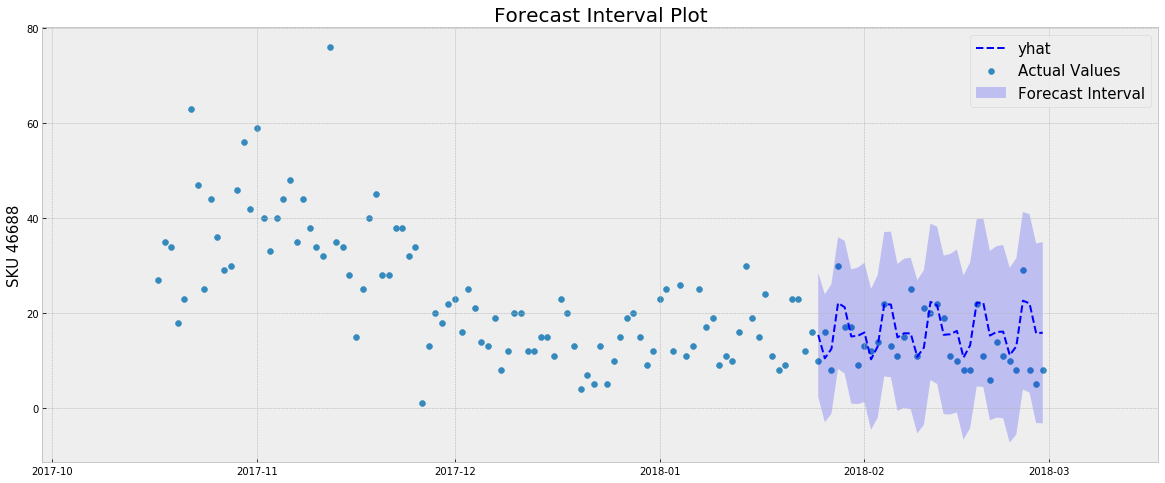

In [4]:
df_interval = pd.DataFrame({
        'y': test,
        'yhat': yhat,
        'sigma_hat': sigma_hat,
        'lower': confident_bounds[:,0],
        'upper': confident_bounds[:,1]
    })
plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='SKU 46688')
plt.show()

# SARIMA

In [21]:
params = {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 7)}

model = SARIMAX(train, **params)
model_fit = model.fit()
yhat = model_fit.forecast(n_test)

In [22]:
model_name = 'SARIMA 46688'
print_relevant_metrics(test, yhat, model_name,  price_mean_test)

-----------------------SARIMA 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 86.4767984062857
Count of Understocked items: 59.00450114803175
Total_Value of Understocked Items: 691.1393901139452
Estimated Monetary Costs: 155.59073741768023
Under/Overstocking Balance Loss: 676.5218098866033
MSE: 25.554698663611457
RMSE: 5.055165542651542
Median Absolut Error 3.4225657826868527
MAP: 4.156608558694785
R2: 0.36635685647064953


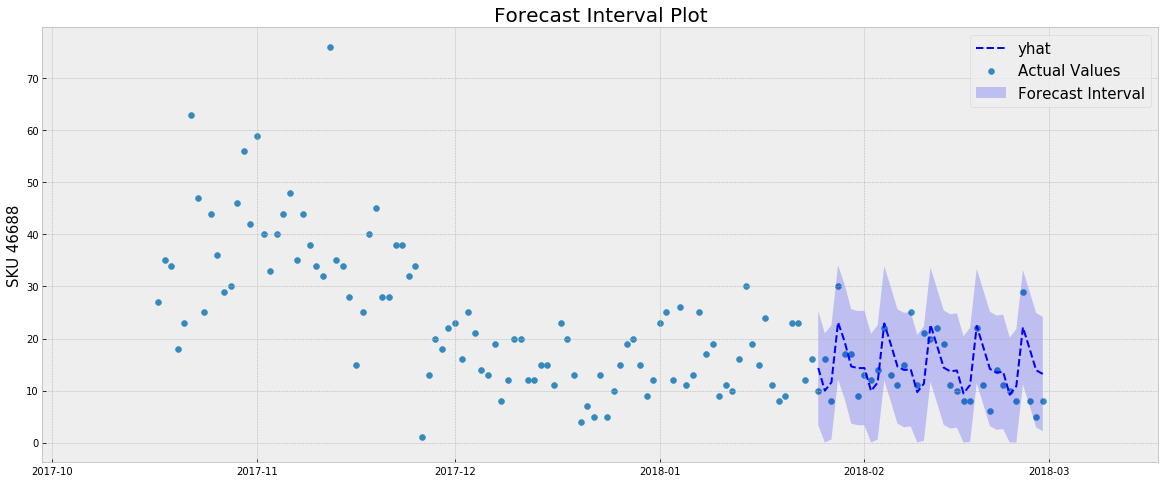

In [11]:
sigma_resid = np.full(n_test, np.std(model_fit.resid))
lower, upper = gaussian_confidence_bands(yhat, sigma_resid, alpha=0.95)

df_interval = pd.DataFrame({
        'y': test,
        'yhat': yhat,
        'sigma_hat': sigma_resid,
        'lower': lower,
        'upper': upper
    })
plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='sold units for product id 46688')
plt.show()

### Tune SARIMA
- according to R2 or to business metric?

In [30]:
from model.sarimax import order_selection

params = {
    'order': [(5,1,1), (10,1,1), (2,1,1), (1,1,10)],
    'seasonal_order': [(5,1,1,7), (1,0,1,7), (10,1,1,7), (1,1,10,7)]
}

order_selection(train, test, params, loss_func=under_overstock_balance_loss)

{'order': (5, 1, 1), 'seasonal_order': (5, 1, 1, 7)}
model fit sucessful
654.7371472991235
{'order': (5, 1, 1), 'seasonal_order': (1, 0, 1, 7)}
model fit sucessful
688.7711923738756
{'order': (5, 1, 1), 'seasonal_order': (10, 1, 1, 7)}
model fit sucessful
764.3333083224964
{'order': (5, 1, 1), 'seasonal_order': (1, 1, 10, 7)}
model fit sucessful
771.3472312620893
{'order': (10, 1, 1), 'seasonal_order': (5, 1, 1, 7)}
model fit sucessful
630.0898251420181
{'order': (10, 1, 1), 'seasonal_order': (1, 0, 1, 7)}
model fit sucessful
468.9617742561949
{'order': (10, 1, 1), 'seasonal_order': (10, 1, 1, 7)}
model fit sucessful
973.7697162247118
{'order': (10, 1, 1), 'seasonal_order': (1, 1, 10, 7)}
model fit sucessful
749.8873675123441
{'order': (2, 1, 1), 'seasonal_order': (5, 1, 1, 7)}
model fit sucessful
663.5018425277952
{'order': (2, 1, 1), 'seasonal_order': (1, 0, 1, 7)}
model fit sucessful
692.8395355609567
{'order': (2, 1, 1), 'seasonal_order': (10, 1, 1, 7)}
model fit sucessful
746.4744

({'order': (10, 1, 1), 'seasonal_order': (1, 0, 1, 7)}, 468.9617742561949)

-----------------------Tuned SARIMA 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 74.83955680920172
Count of Understocked items: 67.50478107031424
Total_Value of Understocked Items: 790.7060022702806
Estimated Monetary Costs: 153.9101570362298
Under/Overstocking Balance Loss: 749.8873675123441
MSE: 24.622914359003246
RMSE: 4.962148159719059
Median Absolut Error 3.2789238687694677
MAP: 4.066981082271885
R2: 0.38946097300261173


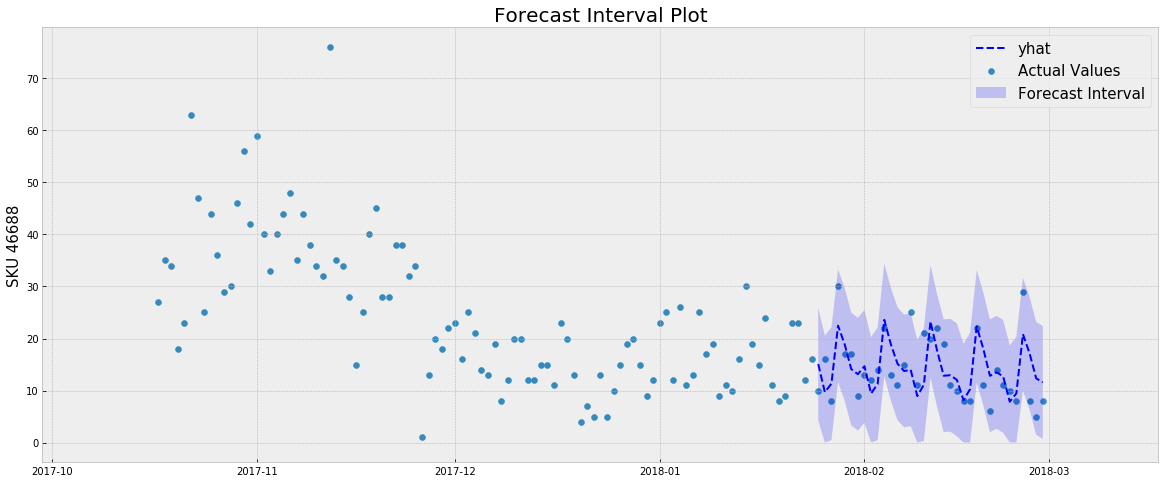

In [54]:
# Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (1, 0, 1, 7)} Loss=468.962
# Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (1, 1, 10, 7)} R2=0.38946097300261173
 
# refit
params = {'order': (10, 1, 1), 'seasonal_order': (1, 1, 10, 7)}

model = SARIMAX(train, **params)
model_fit = model.fit()
yhat = model_fit.forecast(n_test)

model_name = 'Tuned SARIMA 46688'
print_relevant_metrics(test, yhat, model_name,  price_mean_test)

sigma_resid = np.full(n_test, np.std(model_fit.resid))
lower, upper = gaussian_confidence_bands(yhat, sigma_resid, alpha=0.95)

df_interval = pd.DataFrame({
        'y': test,
        'yhat': yhat,
        'sigma_hat': sigma_resid,
        'lower': lower,
        'upper': upper
    })
plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='sold units for product id 46688')
plt.show()

## Adding Exogenous Regressors 
Need to be known for the future horizon! So at the data set at hand we could only create promotion dummy as exogenous variable. Problem: Rarely any promotion happen! For 46688 only one promotion in 3 year has happened

In [47]:
# promotion
promotion = df_sku[(df_sku['promotion_dummy_1'] == 'Yes') | (df_sku['promotion_dummy_2'] == 'Yes')]
promotion

,product_id,website,date,units_sold,selling_price,promotion_dummy_1,promotion_dummy_2,brand,main_category_id,parent_category_id
date,,,,,,,,,,
2017-03-19,46688,2,2017-03-19,3,12.945,Yes,No,1,198,5
2017-03-19,46688,3,2017-03-19,18,10.900,Yes,No,1,198,5
2017-03-19,46688,1,2017-03-19,7,10.900,Yes,No,1,198,5


## SARIMA for all SKUs
- Tuning: minimize MSE (business metric would be better, but without knowing true cost it does not make too much sense)

14530
-----------------------naive model for 14530: Evaluation on y set ----------------------------------
Count of Overstocked items: 16
Count of Understocked items: 27
Total_Value of Understocked Items: 307.98
Estimated Monetary Costs: 46.798
Under/Overstocking Balance Loss: 286
MSE: 2.7142857142857144
RMSE: 1.647508942095828
Median Absolut Error 1.0
MAP: 1.2285714285714286
R2: -0.5788224121557453
1.6894598844439366
1.674878184758327
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (5, 1, 1, 7)} Loss=1.675
-----------------------Tuned SARIMA for 14530: Evaluation on y set ----------------------------------
Count of Overstocked items: 16.0
Count of Understocked items: 20.0
Total_Value of Understocked Items: 228.13333333333333
Estimated Monetary Costs: 38.81333333333333
Under/Overstocking Balance Loss: 216.0
MSE: 1.7142857142857142
RMSE: 1.3093073414159542
Median Absolut Error 1.0
MAP: 1.0285714285714285
R2: 0.002849002849002913


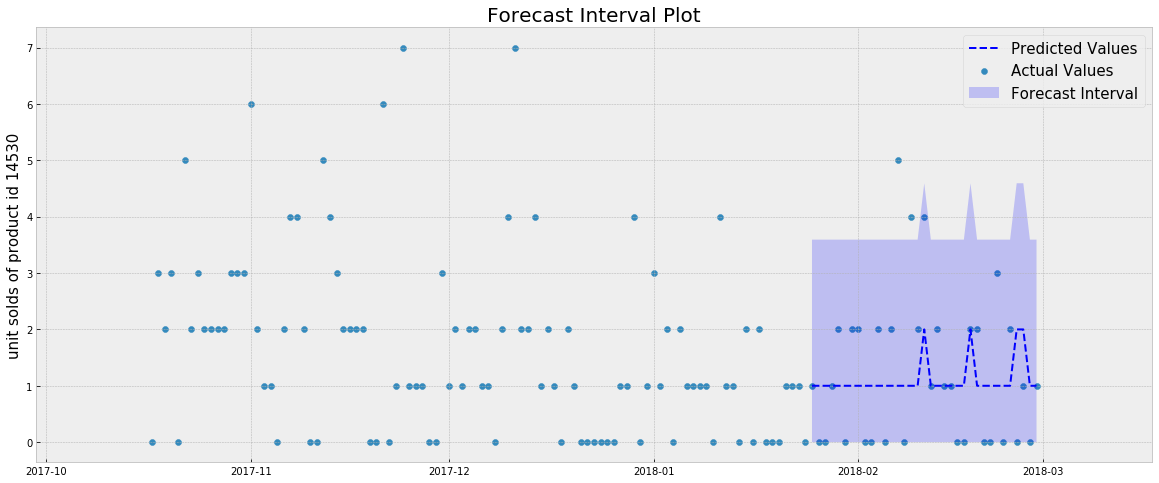

14554
-----------------------naive model for 14554: Evaluation on y set ----------------------------------
Count of Overstocked items: 36
Count of Understocked items: 34
Total_Value of Understocked Items: 420.4666666666667
Estimated Monetary Costs: 78.04666666666667
Under/Overstocking Balance Loss: 376
MSE: 7.085714285714285
RMSE: 2.6619005025947695
Median Absolut Error 2.0
MAP: 2.0
R2: -0.8650623119896861
5.988220203914348
5.925280242659639
Best ARIMA{'order': (1, 1, 10), 'seasonal_order': (10, 1, 1, 7)} Loss=5.925
-----------------------Tuned SARIMA for 14554: Evaluation on y set ----------------------------------
Count of Overstocked items: 40.0
Count of Understocked items: 28.0
Total_Value of Understocked Items: 346.26666666666665
Estimated Monetary Costs: 74.62666666666667
Under/Overstocking Balance Loss: 320.0
MSE: 5.828571428571428
RMSE: 2.4142434484888695
Median Absolut Error 2.0
MAP: 1.9428571428571428
R2: -0.5341641598624838


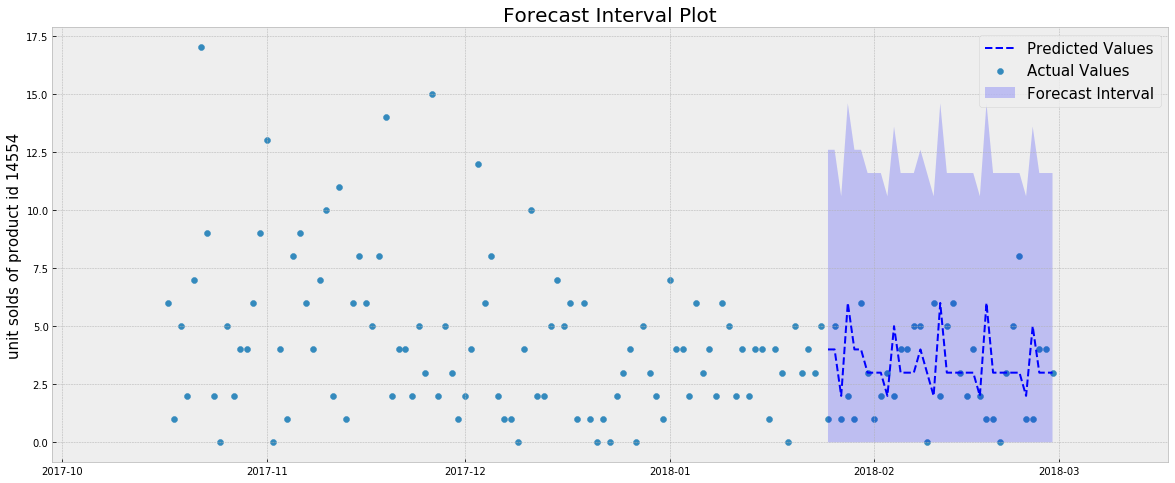

17774
-----------------------naive model for 17774: Evaluation on y set ----------------------------------
Count of Overstocked items: 22
Count of Understocked items: 18
Total_Value of Understocked Items: 240.60000000000008
Estimated Monetary Costs: 46.06
Under/Overstocking Balance Loss: 202
MSE: 2.1142857142857143
RMSE: 1.4540583599999397
Median Absolut Error 1.0
MAP: 1.1428571428571428
R2: -0.37037037037037046
1.7966226455212724
1.7789222740574404
1.7372335352352921
1.5499725748576605
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=1.550


In [ ]:
unique_products = df_sales['product_id'].unique()
for sku in unique_products:
    print(sku)
    df_sku = df[df['product_id'] == sku]  
    y = df_sku['units_sold']
    
    # aggreage daily data
    sold_daily = df_sku['units_sold'].groupby(pd.Grouper(freq='D')).sum()
    prices_mean_daily = df_sku['selling_price'].groupby(pd.Grouper(freq='D')).mean() 

    # split into train test 
    n_test = 35  # 5 weeks of prediction

    train = sold_daily.iloc[:-(n_test)]
    test = sold_daily.tail(n_test)
    price_mean_test = prices_mean_daily.tail(n_test)
    
    yhat_naive = train.tail(n_test)
    print_relevant_metrics(test.values, yhat_naive.values, 'naive model for {}'.format(sku),  price_mean_test)
    
    params = {
    'order': [(5,1,1), (10,1,1), (1,1,10), (1,1,1)],
    'seasonal_order': [(1,1,1,7), (5,1,1,7), (10,1,1,7), (1,1,10,7)]
    }

    best_params, best_score = order_selection(train, test, params, loss_func=metrics.mean_squared_error)
    
    # refit
    model = SARIMAX(train, **best_params)
    model_fit = model.fit()
    yhat = model_fit.forecast(n_test).clip(0).round(0)

    model_name = 'Tuned SARIMA for {}'.format(sku)
    print_relevant_metrics(test, yhat, model_name,  price_mean_test)

    sigma_resid = np.full(n_test, np.std(model_fit.resid))
    lower, upper = gaussian_confidence_bands(yhat, sigma_resid, alpha=0.95)

    df_interval = pd.DataFrame({
            'y': test,
            'yhat': yhat,
            'sigma_hat': sigma_resid,
            'lower': lower,
            'upper': upper
        })
    plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='unit solds of product id {}'.format(sku))
    plt.show()